In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import operator

def test(a, b, cmp, cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a, b), f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a, b, operator.eq, '==')

In [4]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

In [5]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [6]:
path = datasets.download_data(MNIST_URL, ext='.gz')
path

PosixPath('/home/jupyter/.fastai/data/mnist.pkl.gz')

In [7]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [8]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [9]:
assert n == y_train.shape[0] == 50000
test_eq(c, 28*28)
test_eq(y_train.min(), 0)
test_eq(y_train.max(), 9)

In [10]:
mpl.rcParams['image.cmap'] = 'gray'

In [11]:
img = x_train[0]

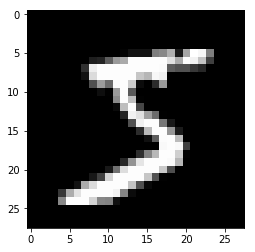

In [12]:
plt.imshow(img.view(28, 28))

In [13]:
weights = torch.randn(784, 10)
bias = torch.zeros(10)

In [24]:
def matmul(a, b):
    # a row, a column
    ar, ac = a.shape
    # b row, b column
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i, j] += a[i, k] * b[k, j]
    return c

In [25]:
m1 = x_valid[:5]
m2 = weights

In [26]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [27]:
%time t1 = matmul(m1, m2)

CPU times: user 1.11 s, sys: 0 ns, total: 1.11 s
Wall time: 1.11 s
